# Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.segmentation import slic
from skimage.morphology import flood
from skimage import measure

# Image acquisition
This is specific to my setup, I'm using my iPhone as an IP camera to automate image acquisition.
If this does not make sense, don't worry, just use the "load image" cell below.

**If no pictures are being taken, just skip until you reach the `Load image` step**

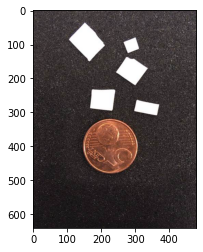

In [20]:
# take a picture from the specified stream

# this should be the en0 stream!
ip = '131.155.241.174'
url = 'http://' + ip + '/live'

if __name__=='__main__':
    cap = cv2.VideoCapture(url)
    ret, img = cap.read()
    cap.release()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Save image

In [3]:
if __name__ == "__main__":
    filename = input(prompt = 'save frame as: ')
    cv2.imwrite(filename, img)

save frame as:  test.png


True

# Load image

open file:  n260_r48_450C_2.png


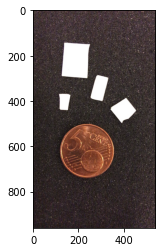

In [2]:
if __name__ == "__main__":
    filename = input(prompt = 'open file: ')
    img = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# SLIC segmentation
See scikit-image documentation, makes clusters based on "closeness", where closeness is a combination of closeness in (x,y)-space and RGB-space. Pixels that are colored alike and are close to each other belong to the same cluster.

https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

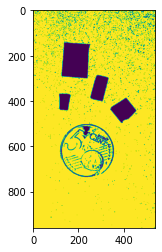

In [3]:
if __name__ == "__main__":
    SLIC_data = slic(img,
           n_segments = 3,
           compactness = 20,
           sigma = 0,
           start_label = 0,
           enforce_connectivity=False)
    plt.imshow(SLIC_data)

# Background detection
One of the clusters is probably the background, just select the biggest cluster, it works for me.

background


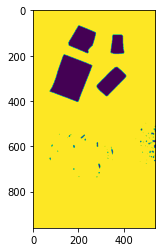

In [6]:
def get_background(SLIC, plot = True):
    values, counts = np.unique(SLIC, return_counts = True)
    background = SLIC == values[counts.argmax()]
    if plot:
        print('background')
        plt.imshow(background)
        plt.show()
    return background

background = get_background(SLIC_data)

# Flood background
This turns out to be irrelevant for execution, but it shows why implicit flooding is good.
The previous image probably had a few blank spots inside the coin, flooding gets rid of that.

foreground


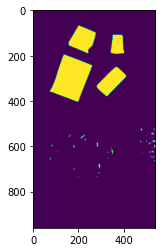

In [7]:
def get_foreground(background, plot = True):
    foreground = ~flood(~background, (0,0))
    if plot:
        print('foreground')
        plt.imshow(foreground)
        plt.show()
    return foreground
    
foreground = get_foreground(background)

# Run whole process
This function takes keyword parameters for `slic` and returns regions and corresponding labels.

**TAKE CARE:**

The regions might contain missing spots, luckily, regionprops objects have fields
* `filled_area`
* `filled_image`

That automatically treat the region as filled.
Not using these might yield incorrect sample sizes!





In [8]:
def pipeline(image, **params):
    # run slic with self tuned defaults
    # these defaults work for me, but I made them easily overwritable
    # just use pipeline(image, compactness = 50) for example
    def slic_defaults(image, **params):
        defaults = {'n_segments' : 4, 
                    'compactness' : 5,
                    'start_label' : 0,
                    'sigma' : 0,
                    'enforce_connectivity' : False}
        # change defaults for values given in params
        for key in params:
            defaults[key] = params[key]
        return slic(image, **defaults)
    
    # run slic with default, but editable, parameters
    print('slic data')
    SLIC = slic_defaults(image, **params)
    plt.imshow(SLIC)
    plt.show()
    # extract the background
    background = get_background(SLIC)
    
    foreground = get_foreground(background)
    # label everything that is not background
    labels = measure.label(~background)
    # and get the regions corresponding to these labels
    regions = measure.regionprops(labels)
    # sort by region size
    regions.sort(key = lambda region: region.filled_area, reverse = True)
    return regions, labels

# Run and check results

slic data


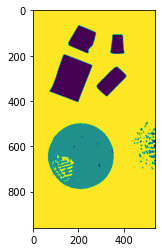

background


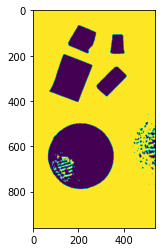

foreground


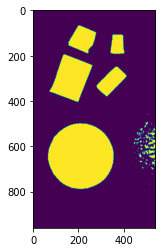

region of size: 65093 pixels


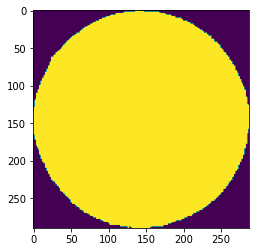

region of size: 23456 pixels


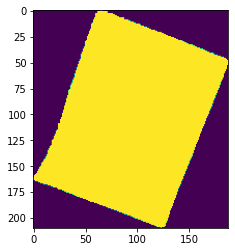

region of size: 9396 pixels


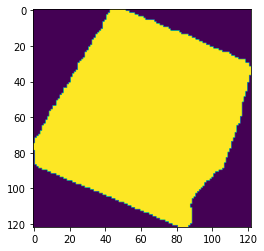

region of size: 8572 pixels


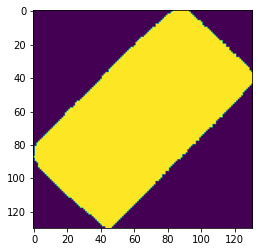

region of size: 4438 pixels


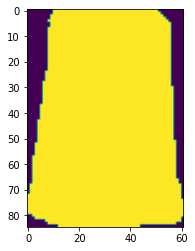

In [11]:
regions, labels = pipeline(img)

N = 5
for region in regions[:N]:
    print(f'region of size: {region.filled_area} pixels')
    plt.imshow(region.filled_image)
    plt.show()